In [1]:
import os
import sys

import openai
from dotenv import find_dotenv, load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langchain_tavily import TavilySearch
from langchain_core.messages import AIMessage, AnyMessage, SystemMessage, ToolMessage, HumanMessage


In [2]:
_ = load_dotenv(find_dotenv())

In [3]:
search_tool = TavilySearch(max_results=5)
print(search_tool.name)
print(search_tool.description)

tavily_search
A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.


In [4]:
model_name = "gpt-3.5-turbo"

In [5]:
model = ChatOpenAI(model=model_name, temperature=0.0)

In [6]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

In [7]:
result = model.invoke("What is the price of bitcoin today?")

In [8]:
result

AIMessage(content='I am sorry, but I am not able to provide real-time information on the price of bitcoin. I recommend checking a reliable financial news website or cryptocurrency exchange for the most up-to-date information.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 15, 'total_tokens': 54, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BtTGqifkMdyJ1olmaFqiEtFVwaVOC', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--6bc4714d-24ef-438f-8ee8-7f04c1c36c3c-0', usage_metadata={'input_tokens': 15, 'output_tokens': 39, 'total_tokens': 54, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [9]:
search_model = model.bind_tools(tools=[search_tool])
result = search_model.invoke("what is the price of bitcoin today?")

In [10]:
result

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2fI7EJOrryHJBpGOPR2dJkzV', 'function': {'arguments': '{"query":"current price of bitcoin","search_depth":"basic"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 839, 'total_tokens': 863, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BtTGrc2Yz5gcRvhS553E71U7v7JJi', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8c5c0e50-c5e2-413b-b870-05f0f68903b9-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'current price of bitcoin', 'search_depth': 'basic'}, 'id': 'call_2fI7EJOrryHJBpGOPR2dJkzV', 'type': 'tool_call'}], usage_metadata={'input_tokens

In [11]:
query = result.tool_calls[0]["args"]["query"]
query

'current price of bitcoin'

In [12]:
from tavily import TavilyClient

client = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])
result = client.search(query, include_answer=True)
result["answer"]

'As of July 15, 2025, Bitcoin is trading at $116,933.57. Its price has fluctuated, with a 24-hour trading volume of $35.23 billion. This reflects the latest known value.'

In [13]:
# create a small agent that finishes when there are no tool calls
# with human in the loop ability

In [14]:
import uuid
import operator
def modify(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    for message in right:
        if not message.id:
            message.id = str(uuid.uuid4())
    merged = left.copy()
    for message in right:
        for i, exists in enumerate(merged):
            if exists.id == message.id:
                merged[i] = message
                break
        else:
            merged.append(message)
    return merged
              

In [15]:
from typing import TypedDict, Annotated

class StateAgent(TypedDict):
    messages: Annotated[list[AnyMessage], modify]

In [16]:
class Agent:
    def __init__(self, model, tools, system_prompt: str="", memory=None):
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools, )#parallel_tool_calls=False)
        self.system_prompt = system_prompt
        self.memory = memory
        graph = StateGraph(StateAgent)
        graph.add_node("llm_call", self.call_llm)
        graph.add_node("tools_calls", self.call_tools)
        graph.add_conditional_edges("llm_call", self.tool_exists, {True: "tools_calls", False: END})
        graph.add_edge("tools_calls", "llm_call")
        graph.set_entry_point("llm_call")
        self.graph = graph.compile(checkpointer=memory,
                                  interrupt_before=["tools_calls"]) # human in the loop

    def call_llm(self, state: StateAgent):
        messages = state["messages"]
        if self.system_prompt:
            messages = [SystemMessage(content=self.system_prompt)] + messages
        messages = self.model.invoke(messages)
        return {"messages": [messages]}

    def tool_exists(self, state: StateAgent):
        print(state)
        tool_calls = state["messages"][-1].tool_calls
        return len(tool_calls) > 0

    def call_tools(self, state: StateAgent):
        tools = state["messages"][-1].tool_calls
        results = []
        for t in tools:
            print(f"Calling...: {t}")
            output = self.tools[t["name"]].invoke(t["args"])
            results.append(ToolMessage(content=str(output),
                                      tool_call_id=t["id"],
                                      name=t["name"]))

        print("Back to Model!")
        return {"messages": results} 
        

In [17]:
system_prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

tavily_search = TavilySearch(max_results=4)
tools = [tavily_search]

In [18]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = 'checkpoints.db'
conn = sqlite3.connect(db_path, check_same_thread=False)

memory = SqliteSaver(conn)

In [19]:
agent_mode = Agent(model=model, system_prompt=system_prompt, tools=tools, memory=memory)

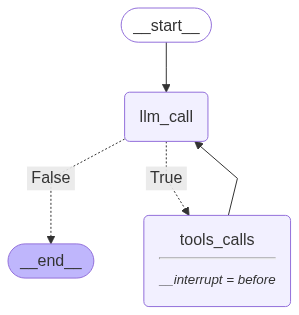

In [20]:
from IPython.display import Image, display

display(Image(agent_mode.graph.get_graph(xray=True).draw_mermaid_png()))

In [21]:
thread = {"configurable": {"thread_id": "1"}}

result = agent_mode.graph.stream({"messages":[ HumanMessage(content="what is the price of bitcoin today?")]},
                                config=thread
                                )

In [22]:
for event in result:
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='what is the price of bitcoin today?', additional_kwargs={}, response_metadata={}, id='fed4faf3-3b1d-41c0-bc02-73a79f450f82'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hEOEIr0N1kCNhG0WS5YwrRFq', 'function': {'arguments': '{"query":"current price of bitcoin","search_depth":"basic"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 904, 'total_tokens': 928, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BtTGxRyPK39uYDdZ8O27fn6QPNQ7A', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--98c9250e-f21e-40c1-a320-63c10296bdbd-0', tool_calls=[{'name': 'tavily_search', '

In [23]:
agent_mode.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='what is the price of bitcoin today?', additional_kwargs={}, response_metadata={}, id='fed4faf3-3b1d-41c0-bc02-73a79f450f82'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hEOEIr0N1kCNhG0WS5YwrRFq', 'function': {'arguments': '{"query":"current price of bitcoin","search_depth":"basic"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 904, 'total_tokens': 928, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BtTGxRyPK39uYDdZ8O27fn6QPNQ7A', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--98c9250e-f21e-40c1-a320-63c10296bdbd-0', tool_calls=[{'name

In [24]:
agent_mode.graph.get_state(thread).next

('tools_calls',)

In [25]:
# continue after interrupt
for event in agent_mode.graph.stream(None, thread):
    for v in event.values():
        print(v)

Calling...: {'name': 'tavily_search', 'args': {'query': 'current price of bitcoin', 'search_depth': 'basic'}, 'id': 'call_hEOEIr0N1kCNhG0WS5YwrRFq', 'type': 'tool_call'}
Back to Model!
{'messages': [ToolMessage(content="{'query': 'current price of bitcoin', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https://www.coinbase.com/price/bitcoin', 'title': 'Bitcoin Price, BTC Price, Live Charts, and Marketcap - Coinbase', 'content': 'BTC is currently trading at $119,791.55. Bitcoin has seen a 1% increase from its 24-hour price of $118,804.83, and is 11% up from its week-ago value of', 'score': 0.9053309, 'raw_content': None}, {'url': 'https://coinmarketcap.com/currencies/bitcoin/', 'title': 'Bitcoin price today, BTC to USD live price, marketcap and chart', 'content': 'The live Bitcoin price today is $118272.03 USD with a 24-hour trading volume of $184072968777.54 USD. We update our BTC to USD price in real-time.', 'score': 0.88799405, 'raw_content': None}, 

In [26]:
agent_mode.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='what is the price of bitcoin today?', additional_kwargs={}, response_metadata={}, id='fed4faf3-3b1d-41c0-bc02-73a79f450f82'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hEOEIr0N1kCNhG0WS5YwrRFq', 'function': {'arguments': '{"query":"current price of bitcoin","search_depth":"basic"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 904, 'total_tokens': 928, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BtTGxRyPK39uYDdZ8O27fn6QPNQ7A', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--98c9250e-f21e-40c1-a320-63c10296bdbd-0', tool_calls=[{'name

In [27]:
agent_mode.graph.get_state(thread).next

()

In [28]:
thread = {"configurable": {"thread_id": "2"}}
message = [HumanMessage(content="who is the current chess champion")]
for event in agent_mode.graph.stream({"messages": message}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='who is the current chess champion', additional_kwargs={}, response_metadata={}, id='4b12399e-f4aa-426d-976a-567b92d95585'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KzVPO4nJ5IOnL8r1cT3X3jFe', 'function': {'arguments': '{"query":"current chess champion","search_depth":"advanced"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 902, 'total_tokens': 925, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BtTH1hhVGSC3E1H941p1xdyKVLqte', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e2449776-facb-4f5c-9f33-44d3e5325814-0', tool_calls=[{'name': 'tavily_search', 'a

In [29]:
agent_mode.graph.get_state(thread).next

('tools_calls',)

In [30]:
while agent_mode.graph.get_state(thread).next:
    print("\n", agent_mode.graph.get_state(thread),"\n")
    input_box = input("Proceed with (y) for yes")
    if input_box != "y":
        print("Tool call aborted")
        break
    for event in agent_mode.graph.stream(None, thread):
        for v in event.values():
            print(v)


 StateSnapshot(values={'messages': [HumanMessage(content='who is the current chess champion', additional_kwargs={}, response_metadata={}, id='4b12399e-f4aa-426d-976a-567b92d95585'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KzVPO4nJ5IOnL8r1cT3X3jFe', 'function': {'arguments': '{"query":"current chess champion","search_depth":"advanced"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 902, 'total_tokens': 925, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BtTH1hhVGSC3E1H941p1xdyKVLqte', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e2449776-facb-4f5c-9f33-44d3e5325814-0', tool_calls=[{'nam

Proceed with (y) for yes y


Calling...: {'name': 'tavily_search', 'args': {'query': 'current chess champion', 'search_depth': 'advanced'}, 'id': 'call_KzVPO4nJ5IOnL8r1cT3X3jFe', 'type': 'tool_call'}
Back to Model!
{'messages': [ToolMessage(content='{\'query\': \'current chess champion\', \'follow_up_questions\': None, \'answer\': None, \'images\': [], \'results\': [{\'url\': \'https://www.chess.com/players\', \'title\': \'The Top Chess Players in the World\', \'content\': "The player\'s full name is Gukesh Dommaraju and they confirmed to Chess.com that they prefer to be called by their first name, Gukesh.\\nIndian GM Gukesh Dommaraju is the current world chess champion, defeating GM Ding Liren in the FIDE World Championship on December 12, 2024. He is the youngest undisputed...\\n\\nArjun Erigaisi\\n\\n## GM Arjun Erigaisi 2776 | #5 [...] Ding Liren is a Chinese chess grandmaster and 17th FIDE world chess champion. He was the world champion from May 2023 to December 2024, earning the title after defeating GM Ian 

In [31]:
thread = {"configurable": {"thread_id": "3"}}
message = [HumanMessage(content="what is the weather in LA")]
for event in agent_mode.graph.stream({"messages": message}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='what is the weather in LA', additional_kwargs={}, response_metadata={}, id='741b0d66-3310-4d16-9220-d7f9627d6d1d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7SrdDcN4F0F7zNn5CSHP3XlB', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 902, 'total_tokens': 922, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BtTHELNLgv9SfXUVNSkqHQzAZmWp5', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--abf4fb3d-6b64-4ee2-bfa7-9fb14862fe2d-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'current w

In [32]:
agent_mode.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='what is the weather in LA', additional_kwargs={}, response_metadata={}, id='741b0d66-3310-4d16-9220-d7f9627d6d1d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7SrdDcN4F0F7zNn5CSHP3XlB', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 902, 'total_tokens': 922, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BtTHELNLgv9SfXUVNSkqHQzAZmWp5', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--abf4fb3d-6b64-4ee2-bfa7-9fb14862fe2d-0', tool_calls=[{'name': 'tavily_search', 'args':

In [33]:
current_state_values = agent_mode.graph.get_state(thread)

In [34]:
current_state_values.values["messages"][-1]

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7SrdDcN4F0F7zNn5CSHP3XlB', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 902, 'total_tokens': 922, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BtTHELNLgv9SfXUVNSkqHQzAZmWp5', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--abf4fb3d-6b64-4ee2-bfa7-9fb14862fe2d-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_7SrdDcN4F0F7zNn5CSHP3XlB', 'type': 'tool_call'}], usage_metadata={'input_tokens': 902, 'output_tokens': 20, 'total_

In [35]:
current_state_values.values["messages"][-1].tool_calls

[{'name': 'tavily_search',
  'args': {'query': 'current weather in Los Angeles'},
  'id': 'call_7SrdDcN4F0F7zNn5CSHP3XlB',
  'type': 'tool_call'}]

In [36]:
_id = current_state_values.values["messages"][-1].tool_calls[0]['id']
current_state_values.values["messages"][-1].tool_calls = [{'name': 'tavily_search',
  'args': {'query': 'weather in Lagos Nigeria'},
  'id': _id,
  'type': 'tool_call'}]

In [37]:
agent_mode.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='what is the weather in LA', additional_kwargs={}, response_metadata={}, id='741b0d66-3310-4d16-9220-d7f9627d6d1d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7SrdDcN4F0F7zNn5CSHP3XlB', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 902, 'total_tokens': 922, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BtTHELNLgv9SfXUVNSkqHQzAZmWp5', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--abf4fb3d-6b64-4ee2-bfa7-9fb14862fe2d-0', tool_calls=[{'name': 'tavily_search', 'args':

In [38]:
agent_mode.graph.update_state(thread, current_state_values.values)

{'messages': [HumanMessage(content='what is the weather in LA', additional_kwargs={}, response_metadata={}, id='741b0d66-3310-4d16-9220-d7f9627d6d1d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7SrdDcN4F0F7zNn5CSHP3XlB', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 902, 'total_tokens': 922, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BtTHELNLgv9SfXUVNSkqHQzAZmWp5', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--abf4fb3d-6b64-4ee2-bfa7-9fb14862fe2d-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'weather i

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f06143a-4359-6c5e-8002-edf1f42a7d6e'}}

In [39]:
agent_mode.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='what is the weather in LA', additional_kwargs={}, response_metadata={}, id='741b0d66-3310-4d16-9220-d7f9627d6d1d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7SrdDcN4F0F7zNn5CSHP3XlB', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 902, 'total_tokens': 922, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BtTHELNLgv9SfXUVNSkqHQzAZmWp5', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--abf4fb3d-6b64-4ee2-bfa7-9fb14862fe2d-0', tool_calls=[{'name': 'tavily_search', 'args':

In [40]:
for event in agent_mode.graph.stream(None, thread):
    for v in event.values():
        print(v)

Calling...: {'name': 'tavily_search', 'args': {'query': 'weather in Lagos Nigeria'}, 'id': 'call_7SrdDcN4F0F7zNn5CSHP3XlB', 'type': 'tool_call'}
Back to Model!
{'messages': [ToolMessage(content='{\'query\': \'weather in Lagos Nigeria\', \'follow_up_questions\': None, \'answer\': None, \'images\': [], \'results\': [{\'title\': \'Weather in Lagos, Nigeria\', \'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Lagos\', \'region\': \'Lagos\', \'country\': \'Nigeria\', \'lat\': 6.4531, \'lon\': 3.3958, \'tz_id\': \'Africa/Lagos\', \'localtime_epoch\': 1752560597, \'localtime\': \'2025-07-15 07:23\'}, \'current\': {\'last_updated_epoch\': 1752560100, \'last_updated\': \'2025-07-15 07:15\', \'temp_c\': 23.0, \'temp_f\': 73.4, \'is_day\': 1, \'condition\': {\'text\': \'Sunny\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/113.png\', \'code\': 1000}, \'wind_mph\': 11.0, \'wind_kph\': 17.6, \'wind_degree\': 250, \'wind_dir\': \'WSW\', \'pressure_mb\': 1018.0

In [41]:
states = []
for state in agent_mode.graph.get_state_history(thread):
    print(state)
    print('--')
    states.append(state)

StateSnapshot(values={'messages': [HumanMessage(content='what is the weather in LA', additional_kwargs={}, response_metadata={}, id='741b0d66-3310-4d16-9220-d7f9627d6d1d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7SrdDcN4F0F7zNn5CSHP3XlB', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 902, 'total_tokens': 922, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BtTHELNLgv9SfXUVNSkqHQzAZmWp5', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--abf4fb3d-6b64-4ee2-bfa7-9fb14862fe2d-0', tool_calls=[{'name': 'tavily_search', 'args':

In [42]:
states

[StateSnapshot(values={'messages': [HumanMessage(content='what is the weather in LA', additional_kwargs={}, response_metadata={}, id='741b0d66-3310-4d16-9220-d7f9627d6d1d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7SrdDcN4F0F7zNn5CSHP3XlB', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 902, 'total_tokens': 922, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BtTHELNLgv9SfXUVNSkqHQzAZmWp5', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--abf4fb3d-6b64-4ee2-bfa7-9fb14862fe2d-0', tool_calls=[{'name': 'tavily_search', 'args'

In [43]:
replay = states[-3]

In [44]:
replay

StateSnapshot(values={'messages': [HumanMessage(content='what is the weather in LA', additional_kwargs={}, response_metadata={}, id='741b0d66-3310-4d16-9220-d7f9627d6d1d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7SrdDcN4F0F7zNn5CSHP3XlB', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 902, 'total_tokens': 922, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BtTHELNLgv9SfXUVNSkqHQzAZmWp5', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--abf4fb3d-6b64-4ee2-bfa7-9fb14862fe2d-0', tool_calls=[{'name': 'tavily_search', 'args':

In [45]:
for event in agent_mode.graph.stream(None, replay.config):
    for k, v in event.items():
        print(v)

Calling...: {'name': 'tavily_search', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_7SrdDcN4F0F7zNn5CSHP3XlB', 'type': 'tool_call'}
Back to Model!
{'messages': [ToolMessage(content='{\'query\': \'current weather in Los Angeles\', \'follow_up_questions\': None, \'answer\': None, \'images\': [], \'results\': [{\'title\': \'Weather in Los Angeles\', \'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Los Angeles\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 34.0522, \'lon\': -118.2428, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1752560267, \'localtime\': \'2025-07-14 23:17\'}, \'current\': {\'last_updated_epoch\': 1752560100, \'last_updated\': \'2025-07-14 23:15\', \'temp_c\': 17.8, \'temp_f\': 64.0, \'is_day\': 0, \'condition\': {\'text\': \'Overcast\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/night/122.png\', \'code\': 1009}, \'wind_mph\': 3.8, \'wind_kph\': 6.1, \'wind_degree\': 

In [46]:
replay

StateSnapshot(values={'messages': [HumanMessage(content='what is the weather in LA', additional_kwargs={}, response_metadata={}, id='741b0d66-3310-4d16-9220-d7f9627d6d1d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7SrdDcN4F0F7zNn5CSHP3XlB', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 902, 'total_tokens': 922, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BtTHELNLgv9SfXUVNSkqHQzAZmWp5', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--abf4fb3d-6b64-4ee2-bfa7-9fb14862fe2d-0', tool_calls=[{'name': 'tavily_search', 'args':

In [47]:
replay.values['messages'][-1].tool_calls

[{'name': 'tavily_search',
  'args': {'query': 'current weather in Los Angeles'},
  'id': 'call_7SrdDcN4F0F7zNn5CSHP3XlB',
  'type': 'tool_call'}]

In [48]:
_id = replay.values['messages'][-1].tool_calls[0]['id']
replay.values['messages'][-1].tool_calls = [{'name': 'tavily_search',
  'args': {'query': 'current weather in LA, accuweather'},
  'id': _id}]

In [49]:
branch_state = agent_mode.graph.update_state(replay.config, replay.values)

{'messages': [HumanMessage(content='what is the weather in LA', additional_kwargs={}, response_metadata={}, id='741b0d66-3310-4d16-9220-d7f9627d6d1d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7SrdDcN4F0F7zNn5CSHP3XlB', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 902, 'total_tokens': 922, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BtTHELNLgv9SfXUVNSkqHQzAZmWp5', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--abf4fb3d-6b64-4ee2-bfa7-9fb14862fe2d-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'current w

In [50]:
for event in agent_mode.graph.stream(None, branch_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)

Calling...: {'name': 'tavily_search', 'args': {'query': 'current weather in LA, accuweather'}, 'id': 'call_7SrdDcN4F0F7zNn5CSHP3XlB', 'type': 'tool_call'}
Back to Model!
{'messages': [ToolMessage(content='{\'query\': \'current weather in LA, accuweather\', \'follow_up_questions\': None, \'answer\': None, \'images\': [], \'results\': [{\'title\': \'Weather in Los Angeles, CA\', \'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Los Angeles\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 34.0522, \'lon\': -118.2428, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1752561221, \'localtime\': \'2025-07-14 23:33\'}, \'current\': {\'last_updated_epoch\': 1752561000, \'last_updated\': \'2025-07-14 23:30\', \'temp_c\': 17.8, \'temp_f\': 64.0, \'is_day\': 0, \'condition\': {\'text\': \'Overcast\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/night/122.png\', \'code\': 1009}, \'wind_mph\': 3.8, \'wind_kph\': 6.1, \'win

In [51]:
replay

StateSnapshot(values={'messages': [HumanMessage(content='what is the weather in LA', additional_kwargs={}, response_metadata={}, id='741b0d66-3310-4d16-9220-d7f9627d6d1d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7SrdDcN4F0F7zNn5CSHP3XlB', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 902, 'total_tokens': 922, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BtTHELNLgv9SfXUVNSkqHQzAZmWp5', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--abf4fb3d-6b64-4ee2-bfa7-9fb14862fe2d-0', tool_calls=[{'name': 'tavily_search', 'args':

In [51]:
_id = replay.values['messages'][-1].tool_calls[0]['id']

In [52]:
state_update = {"messages": [ToolMessage(
    tool_call_id=_id,
    name="tavily_search",
    content="54 degree celcius",
)]}

In [53]:
branch_and_add = agent_mode.graph.update_state(
    replay.config, 
    state_update, 
    as_node="tools_calls")

In [55]:
for event in agent_mode.graph.stream(None, branch_and_add):
    for k, v in event.items():
        print(v)

{'messages': [HumanMessage(content='what is the weather in LA', additional_kwargs={}, response_metadata={}, id='741b0d66-3310-4d16-9220-d7f9627d6d1d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7SrdDcN4F0F7zNn5CSHP3XlB', 'function': {'arguments': '{"query":"current weather in Los Angeles"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 902, 'total_tokens': 922, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BtTHELNLgv9SfXUVNSkqHQzAZmWp5', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--abf4fb3d-6b64-4ee2-bfa7-9fb14862fe2d-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'current w

In [56]:
replay.config

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f061437-4f2e-66a5-8001-fe60549f3042'}}